In [2]:
import numpy as np
import xgboost as xgb
from sklearn import svm
from sklearn import datasets
from sklearn.cluster import KMeans
from matplotlib import pylab as plt
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error
from seqmml import SeqUD, GPEIOPT, SMACOPT, TPEOPT

# Example 1: SVM for Classification

In [3]:
sx = MinMaxScaler()
dt = datasets.load_breast_cancer()
x = sx.fit_transform(dt.data)
y = dt.target

ParaSpace = {'C':{'Type': 'continuous', 'Range': [-6, 16], 'Wrapper': np.exp2}, 
       'gamma': {'Type': 'continuous', 'Range': [-16, 6], 'Wrapper': np.exp2}}

estimator = svm.SVC()
score_metric = make_scorer(accuracy_score, True)
cv = KFold(n_splits=5, random_state=0, shuffle=True)

In [4]:
sequd_clf = SeqUD(ParaSpace, n_runs_per_stage=20, max_runs=100, max_search_iter=100, n_jobs=1, 
                 estimator=estimator, cv=cv, scoring=score_metric, refit=None, verbose=True)
sequd_clf.fit(x, y)


Stage 1 completed (20/100) with best score: 0.97895.
Stage 2 completed (34/100) with best score: 0.97895.
Stage 3 completed (48/100) with best score: 0.98070.
Stage 4 completed (62/100) with best score: 0.98246.
Stage 5 completed (78/100) with best score: 0.98246.
Stage 6 completed (95/100) with best score: 0.98246.
Maximum number of runs reached, stop!
SeqUD completed in 7.69 seconds.
The best score is: 0.98246.
The best configurations are:
C                   : 10.19649
gamma               : 1.28565


In [7]:
sequd_clf.search_time_consumed_

7.691547155380249

In [ ]:
sequd_clf = SeqUD(ParaSpace, n_runs_per_stage=20, max_runs=100, max_search_iter=100, n_jobs=1, 
                 estimator=estimator, cv=cv, scoring=score_metric, refit=None, verbose=True)
sequd_clf.fit(x, y)

tpe_clf = TPEOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric, refit=True, verbose=True)
tpe_clf.fit(x, y)

smac_clf = SMACOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric, refit=True, verbose=True)
smac_clf.fit(x, y)

gpei_clf = GPEIOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, scoring=score_metric, refit=True, verbose=True)
gpei_clf.fit(x, y)

A contour plot based on a thorough grid search

In [4]:
def plot_trajectory(Z, clf, title):
    levels = [0.2, 0.4, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0]
    cp = plt.contourf(X, Y, Z, levels)
    plt.colorbar(cp)
    plt.xlabel('Log2_C')
    plt.ylabel('Log2_gamma')
    plt.scatter(np.log2(clf.logs.loc[:, ['C']]), 
                np.log2(clf.logs.loc[:, ['gamma']]), color="red")
    plt.title(title)

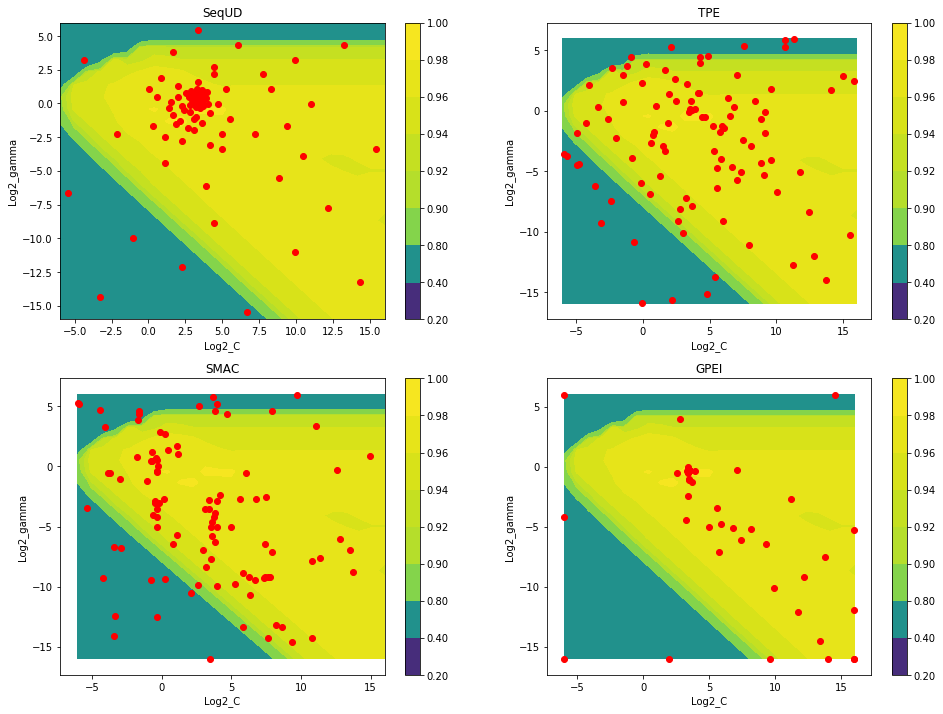

In [5]:
grid_num = 25
xlist = np.linspace(-6, 16, grid_num)
ylist = np.linspace(-16, 6, grid_num)
X, Y = np.meshgrid(xlist, ylist)
Z = np.zeros((grid_num, grid_num))
for i, C in enumerate(xlist):
    for j, gamma in enumerate(ylist):
        estimator = svm.SVC(C=2 ** C, gamma=2 ** gamma)
        out = cross_val_score(estimator, x, y, cv=cv, scoring=score_metric)
        Z[j,i] = np.mean(out)
        
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plot_trajectory(Z, sequd_clf, "SeqUD")

plt.subplot(2, 2, 2)
plot_trajectory(Z, tpe_clf, "TPE")

plt.subplot(2, 2, 3)
plot_trajectory(Z, smac_clf, "SMAC")

plt.subplot(2, 2, 4)
plot_trajectory(Z, gpei_clf, "GPEI")

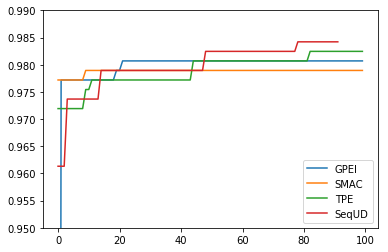

In [6]:
plt.plot(gpei_clf.logs["score"].cummax()) 
plt.plot(smac_clf.logs["score"].cummax()) 
plt.plot(tpe_clf.logs["score"].cummax())
plt.plot(sequd_clf.logs["score"].cummax()) 
plt.legend(['GPEI', 'SMAC', 'TPE', 'SeqUD'])
plt.ylim(0.95, 0.99)
plt.show()

# Example :Xgboost for Regression

In [12]:
import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error
from seqmml import SeqUD

dt = datasets.load_diabetes()
x = MinMaxScaler().fit_transform(dt.data)
y = MinMaxScaler().fit_transform(dt.target.reshape([-1, 1]))
ParaSpace = {'booster':          {'Type': 'categorical', 'Mapping': ['gbtree', 'gblinear']},
             'max_depth':        {'Type': 'integer',     'Mapping': np.linspace(2, 9, 8)}, 
             'n_estimators':     {'Type': 'integer',     'Mapping': np.linspace(100, 500, 401)},
             'colsample_bytree': {'Type': 'continuous',  'Range': [0, 1],  'Wrapper': lambda x:x},
             'learning_rate':    {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'gamma':            {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'reg_lambda':       {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x},
             'reg_alpha':        {'Type': 'continuous',  'Range': [-5, 0], 'Wrapper': lambda x: 10**x}}
sequd_clf = SeqUD(ParaSpace, n_runs_per_stage=20, max_runs=100, max_search_iter=100, n_jobs=1, 
                  estimator=xgb.XGBRegressor(), cv=KFold(n_splits=5, random_state=0, shuffle=True),
                  refit=None, random_state=0, verbose=True)
sequd_clf.fit(x, y)

Stage 1 completed (20/100) with best score: 0.48824.
Stage 2 completed (38/100) with best score: 0.48950.
Stage 3 completed (56/100) with best score: 0.48950.
Stage 4 completed (74/100) with best score: 0.48950.
Stage 5 completed (92/100) with best score: 0.48951.
Maximum number of runs reached, stop!
SeqUD completed in 47.21 seconds.
The best score is: 0.48951.
The best configurations are:
booster             : gblinear
max_depth           : 4
n_estimators        : 286
colsample_bytree    : 0.825
learning_rate       : 0.89769
gamma               : 0.23714
reg_lambda          : 0.00078
reg_alpha           : 8e-05


TPE completed in 57.29 seconds.
The best score is: 0.48982.
The best configurations are:
booster             : gblinear
max_depth           : 7
n_estimators        : 416
colsample_bytree    : 0.53886
learning_rate       : 0.98501
gamma               : 0.00366
reg_lambda          : 2e-05
reg_alpha           : 0.00076



SMAC completed in 273.46 seconds.
The best score is: 0.48730.
The best configurations are:
booster             : gblinear
max_depth           : 5
n_estimators        : 268
colsample_bytree    : 0.82708
learning_rate       : 0.63598
gamma               : 0.11219
reg_lambda          : 0.00015
reg_alpha           : 3e-05



GPEI completed in 532.65 seconds.
The best score is: 0.46570.
The best configurations are:
booster             : gbtree
max_depth           : 2
n_estimators        : 500
colsample_bytree    : 0.87592
learning_rate       : 0.11086
gamma               : 0.01343
reg_lambda          : 1e-05
reg_alpha           : 0.89989



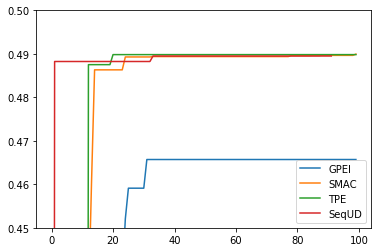

In [10]:
plt.plot(gpei_clf.logs["score"].cummax()) 
plt.plot(smac_clf.logs["score"].cummax()) 
plt.plot(tpe_clf.logs["score"].cummax())
plt.plot(sequd_clf.logs["score"].cummax()) 
plt.legend(['GPEI', 'SMAC', 'TPE', 'SeqUD'])
plt.ylim(0.45, 0.5)
plt.show()

 # Example 3: Kmeans for Unsupervised Clustering  

In [10]:
sx = MinMaxScaler()
dt = datasets.load_iris()
x = sx.fit_transform(dt.data)
y = dt.target.reshape([-1,1])

ParaSpace = {'n_clusters':  {'Type': 'integer',    'Mapping': np.linspace(2, 9, 8)}, 
             'tol':         {'Type': 'continuous', 'Range': [-6, -3], 'Wrapper': lambda x: 10**x}}
estimator = KMeans()
cv = KFold(n_splits=5, random_state=0, shuffle=True)

In [11]:
sequd_clf = SeqUD(ParaSpace, n_runs_per_stage=20, max_runs=100, max_search_iter=100, n_jobs=10, 
                 estimator=estimator, cv=cv, refit=None, verbose=True)
sequd_clf.fit(x)

tpe_clf = TPEOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, refit=True, random_state=0, verbose=True)
tpe_clf.fit(x)

smac_clf = SMACOPT(ParaSpace,max_runs=100, estimator=estimator, cv=cv, refit=True, random_state=0, verbose=True)
smac_clf.fit(x)

gpei_clf = GPEIOPT(ParaSpace, max_runs=100, estimator=estimator, cv=cv, refit=True, random_state=0, verbose=True)
gpei_clf.fit(x)

Stage 1 completed (20/100) with best score: -0.71826.
Stage 2 completed (34/100) with best score: -0.67775.
Stage 3 completed (50/100) with best score: -0.67775.
Stage 4 completed (65/100) with best score: -0.67775.
Stage 5 completed (80/100) with best score: -0.67775.
Stage 6 completed (95/100) with best score: -0.67775.
Maximum number of runs reached, stop!
SeqUD completed in 10.49 seconds.
The best score is: -0.67775.
The best configurations are:
n_clusters          : 9
tol                 : 0.0


TPE completed in 22.25 seconds.
The best score is: -0.70273.
The best configurations are:
n_clusters          : 9
tol                 : 1e-05



SMAC completed in 69.34 seconds.
The best score is: -0.68854.
The best configurations are:
n_clusters          : 9
tol                 : 6e-05



GPEI completed in 427.32 seconds.
The best score is: -0.68084.
The best configurations are:
n_clusters          : 9
tol                 : 1e-05



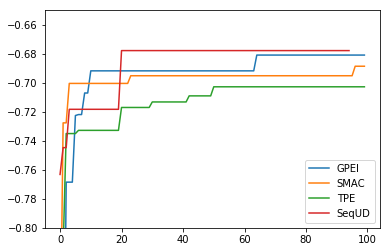

In [12]:
plt.plot(gpei_clf.logs["score"].cummax()) 
plt.plot(smac_clf.logs["score"].cummax()) 
plt.plot(tpe_clf.logs["score"].cummax())
plt.plot(sequd_clf.logs["score"].cummax()) 
plt.legend(['GPEI', 'SMAC', 'TPE', 'SeqUD'])
plt.ylim(-0.8, -0.65)
plt.show()